# Twitter Analysis

Use this notebook to perform some advanced analytics on your Twitter data.  We will cover the following topics:

1) Build a retweet network from a database of tweets

2) Calculate centralities on retweet network

3) Find giant component of retweet network and draw it

4) Build a similarity network based on who people retweet

5) Cluster users based on similarity network

6) Make a word cloud for each cluster

7) Filter out tweets by keyword or retweet source

## Import packages

We will import the packages we installed, along with some helper functions.

In [1]:
from datetime import datetime, timedelta
import numpy as np
import sqlite3, sys, os
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
import seaborn as sns
import codecs  #this let's us display tweets properly (emojis, etc.)
import regex as re
#helper code
import scripts.scraper_twitter_api as api
from scripts.create_graph import *

from scripts.Communities import spectral_communities
from scripts.Communities import umap_layout,network_thinner

import scripts.TextAnalysis as ta
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator


pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', None)

# Build Retweet Network

We will have the tweets in a database file `'data/tweets_keyword_doge.db'`.  We will load the database into a dataframe `df`.  We add in a column `text_clean` for cleaned tweet text and a column `retweet_source` for the source of the retweet if the tweet is a retweet.

Then we use the function `retweet_network_from_tweets` to build the retweet network, where each edge points for a source user to a retweeter.

In [2]:
fname = 'data/tweets_keyword_doge.db'
conn = sqlite3.connect(fname)
df = pd.read_sql_query("SELECT * FROM tweet", conn)
df['text_clean'] = df.text.apply(ta.clean_tweet)  #clean the tweets
df['retweet_source'] = df.text.apply(extract_source)

df[['screen_name','text','retweet_source']].head()

,screen_name,text,retweet_source
0,VAvediti,RT @Jbradt31: $DOGE 0.10 by April 1st. #Dogecoin \U0001f680\U0001f4c8,Jbradt31
1,SalazarStonks,"\U0001f6a8 \U0001f6a8 \U0001f6a8 Honestly people, $HOGE is definitely going to be THE BIGGEST play of this month.. if not this year. Early inv\u2026 https://t.co/x7RjWJD320",None
2,Hailey_ruth,RT @elonmusk: Doge spelled backwards is Egod,elonmusk
3,doge_another,RT @doge_another: RETWEET IF YOU\u2019RE STILL #HODLING \U0001f440 #DOGE #dogecoin #dogearmy #DogecoinToTheMoon #crypto https://t.co/QeCCvKslWi,doge_another
4,LuckygcRiego331,RT @BenPhillipsUK: NEW 100k #DOGE GIVEAWAY! all you goto do! Is \u2764\ufe0f and RT this then follow me! Then where ever you are in the world shout \u201c\u2026,BenPhillipsUK


In [3]:
G = retweet_network_from_tweets(df)

ne = G.number_of_edges()
nv = G.number_of_nodes()



went through 4919 tweets, found 3131 retweets, 2922 retweet edges
Retweet network has 2115 nodes and 2922 edges


## Network Centrality Analysis of Retweet Network

In [4]:
Din = nx.in_degree_centrality(G)
Dout = nx.out_degree_centrality(G)
CC = nx.closeness_centrality(G.reverse())  #reverse edges to match networx convention
BC = nx.betweenness_centrality(G)
EC = nx.eigenvector_centrality(G.reverse())  #reverse edges to match networx convention

#For plotting, we combine all the centrality dictionaries into a dataframe
dictionary_list = []
for screen_name in Din.keys():
    row = {'screen_name':screen_name,
          'in_degree_centrality':Din[screen_name],
          'out_degree_centrality':Dout[screen_name],
          'closeness_centrality':CC[screen_name],
          'betweenness_centrality':BC[screen_name],
          'eigenvector_centrality':EC[screen_name]}
    dictionary_list.append(row)
df_centrality = pd.DataFrame(dictionary_list)

df_centrality.sort_values(by = ['out_degree_centrality'],ascending = False).head()


,screen_name,in_degree_centrality,out_degree_centrality,closeness_centrality,betweenness_centrality,eigenvector_centrality
82,elon_finance,0.001419,0.043519,0.042389,0.000065,3.127057e-07
15,itsALLrisky,0.000000,0.034532,0.034798,0.000000,3.127057e-07
55,dogecoin_rise,0.000000,0.034532,0.032769,0.000000,1.172060e-04
90,ItsDogeCoin,0.000000,0.030274,0.022290,0.000000,8.839799e-05
48,CryptAbby,0.000473,0.027909,0.027610,0.000013,3.127057e-07


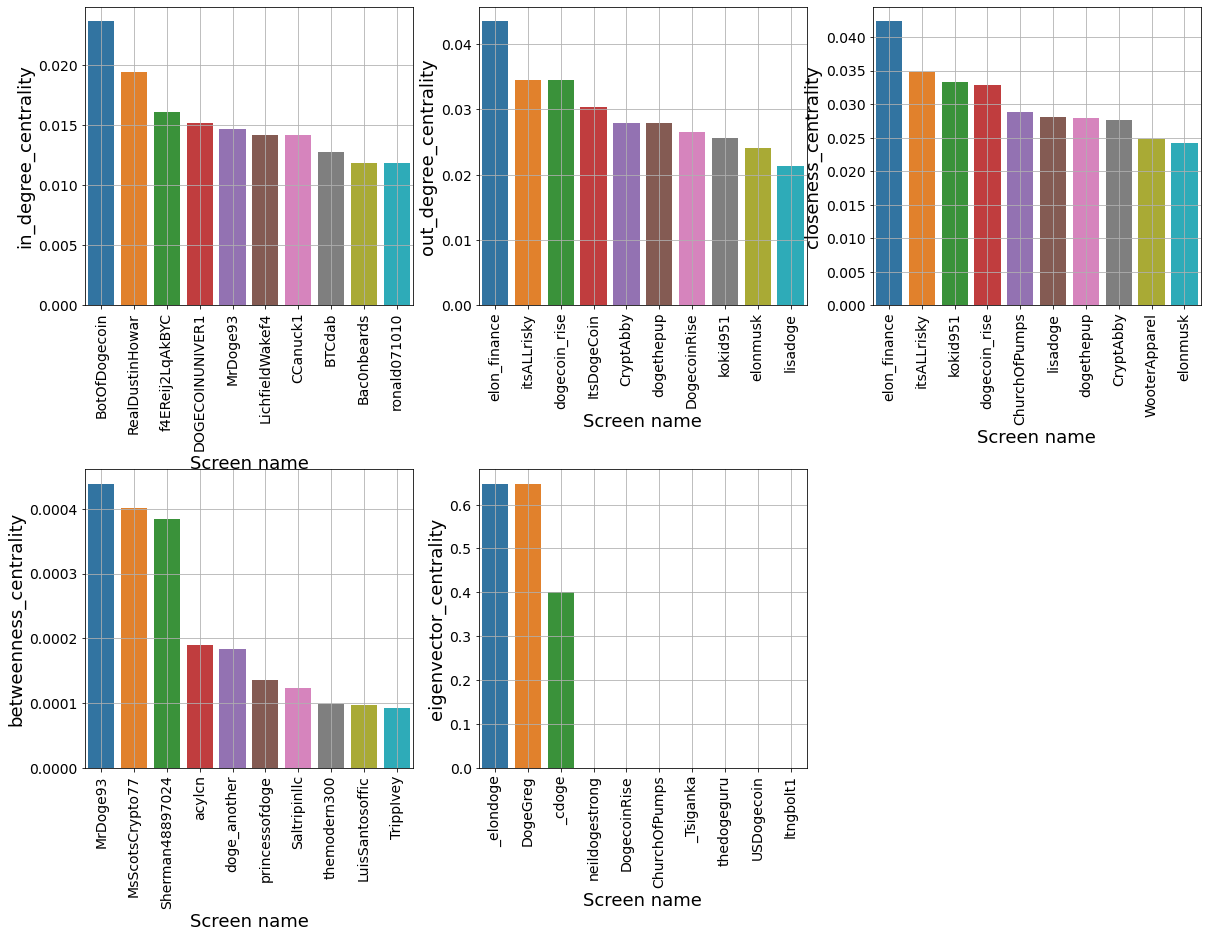

In [5]:
Centrality_names = df_centrality.columns.tolist()[1:]
kmax = 10  #show top kmax users


fig = plt.figure(figsize = (20,14))

for count,centrality_name in enumerate(Centrality_names):    
    df_plot = df_centrality.sort_values(by=[centrality_name],ascending=False)  #sort dataframe by centrality value
    plt.subplot(2,3,count+1) #make a 2 x 3 subplot, plot in box cnt+1
    
    ax = sns.barplot(data=df_plot[0:kmax], x='screen_name', y=centrality_name)
    ax.set_xticklabels(ax.get_xticklabels(),rotation = 90)
    plt.xticks(fontsize = 14)
    plt.yticks(fontsize = 14)
    plt.ylabel(f"{centrality_name}",fontsize = 18)
    plt.xlabel('Screen name',fontsize = 18)
    plt.grid()

plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=None, hspace=0.55)

plt.show()

## Connected Components of Network

We will use the `connected_components` function on the undirected version of the retweet network to find the connected components.  Then we will make a bar graph of the component sizes to identify the giant component.  This giant component is the one we will draw.


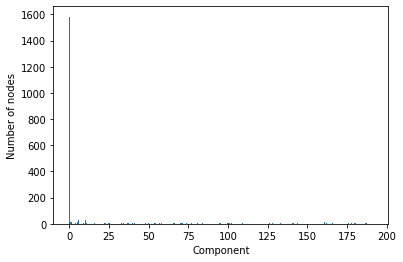

In [6]:
C = nx.connected_components(G.to_undirected())

csizes = []
cindices = []
for count,c in enumerate(C):
    csizes.append(len(c))
    cindices.append(count)
plt.bar(cindices,csizes)
plt.xlabel("Component")
plt.ylabel("Number of nodes")
plt.show()

## Create Subgraph of Giant Component

We recalculate the connected components and create a subgraph of the giant component called `Gsub`.  Then we can draw this component.

In [7]:
Gcc = sorted(nx.connected_components(G.to_undirected()), key=len, reverse=True)
Gsub = G.subgraph(Gcc[0])  

## Draw Giant Component

In [8]:
%time pos =umap_layout(Gsub.to_undirected())



Wall time: 9.32 s


In [9]:
def draw_network_pos(G,pos,node_color = 'pink'):
    node_size = 2
    width = 0.05
    edge_color = "white"
    bg_color = "black"

    fig = plt.figure(figsize= (8,6))
    ax = plt.subplot(1,1,1)
    nx.draw(G, width=width,pos=pos ,node_color=node_color,
            edge_color=edge_color,node_size=node_size,
            connectionstyle='arc3')
    fig.set_facecolor(bg_color)
   
    return ax

Wall time: 72.3 ms


<AxesSubplot:>

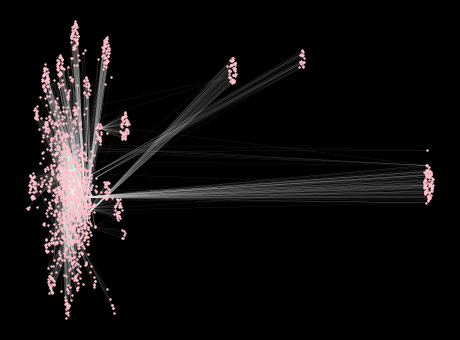

In [10]:
%time draw_network_pos(Gsub.to_undirected(),pos)

# Similarity Network Based on Retweets

The retweet network is not good for clustering users.  This is because two users can retweet the same people, indicating that they are similar and should be in the same cluster, but have no edge connecting them.  To get around this, we can make a similarity network where two users share an undirected edge with a weight that indicates how similar they are. We will measure similarity based on who the users retweet.  If they retweet the exact same people, the similarity is 1, and if they don't retweet anyone in common, the similarity is zero.  To measure the similarity of the retweet sets of a pair of users, we use the Jaccard coefficient.  You can read more about the Jaccard coefficient in Networx here: 
https://networkx.org/documentation/networkx-1.10/reference/generated/networkx.algorithms.link_prediction.jaccard_coefficient.html


The code below creates the retweet similarity network `Gsim` using the function `retweet_similarity_network`.  There is an edge between each pair of nodes with Jaccard coefficient greater than zero.  You can save the network by defining a file name `fname_Gsim`.

In [11]:
fname_Gsim = 'data/Gsim.gpickle'

Gsim = retweet_similarity_network(G)
print("Save similarity graph Gsim")
nx.write_gpickle(Gsim, fname_Gsim)

2115 nodes in retweet network
2235555  node pairs to check Jaccard index
Create similarity graph between bots using Jacard index based on retweets
1000000 23770  positive weights
2000000 35985  positive weights
Gsim has 1797 nodes, 39712 edges
Save similarity graph Gsim


## Find Spectral Communities in Similarity Graph

We can use `Gsim` to find communities of users that retweet similar users. We will focus on the giant connected component of the graph to avoid issues with spectral clustering.

In [12]:
Gcc = sorted(nx.connected_components(Gsim), key=len, reverse=True)
Gsub = Gsim.subgraph(Gcc[0])

<AxesSubplot:xlabel='community', ylabel='Count'>

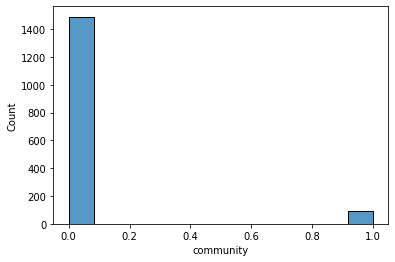

In [13]:
df_spec = spectral_communities(Gsub,2)
sns.histplot(data = df_spec, x = 'community')

## Draw Similarity Network with Community Colors

In [14]:
%time pos =nx.spring_layout(Gsub)


Wall time: 11.8 s


In [15]:
Colors = ['blue','red']
node_color = [Colors[df_spec.community[df_spec.screen_name==node].values[0]] for node in df_spec.screen_name]


Wall time: 407 ms


<AxesSubplot:>

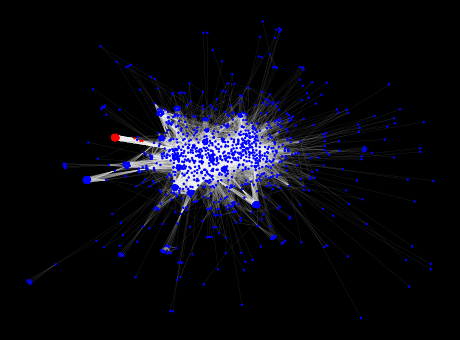

In [16]:
%time draw_network_pos(Gsub,pos,node_color)

## Wordcloud Tweets in Each Community

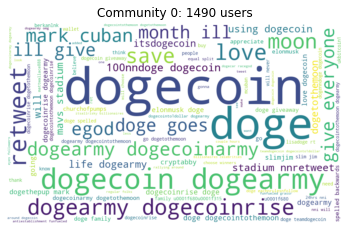

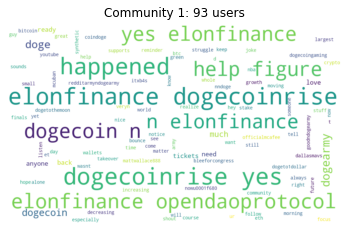

In [17]:
for community in df_spec.community.unique():
    V = df_spec.screen_name[df_spec.community==community].tolist()

    df1 = df[df.screen_name.isin(V)]

    text=' '.join(df1.text_clean.tolist()).lower()
    stopwords = set(STOPWORDS)

    wordcloud = WordCloud(stopwords=stopwords,max_font_size=150, max_words=100, background_color="white",width=1000, height=600)
    wordcloud.generate(text)

    plt.imshow(wordcloud, interpolation="bilinear")
    plt.title(f"Community {community}: {len(V)} users")
    plt.axis("off")
    plt.show()

# Find Tweets Containing at Least One Keyword

You may want to find tweets that contain at least one word from a list of keywords.  Define the keyword list `keywords`.  Then the code below will return a dataframe `df_keywords` that only has tweets with the keywords.

In [3]:
keywords = ['dogecointothemoon','dogearmy']



In [4]:
df_keywords = df[df.text.str.contains('|'.join(keywords), flags=re.IGNORECASE)] 
print(f"df has {len(df)} tweets")
print(f"df_keywords has {len(df_keywords)} tweets")


df has 4919 tweets
df_keywords has 1523 tweets


In [5]:
df_keywords.text.sample(n=10).tolist()

['style points \\U0001f4c8\\U0001f680#doge #dogecoin #dogecar #racegod #dogetothemoon #dogecoinrise #dogearmy #crypto https://t.co/Ul8DG7st8T ',
 'RT @itsALLrisky: Look what @SlimJim is doing. They\\u2019re embracing #DOGE and interacting with the #DogeArmy \\n\\nMemes make for good marketing, a\\u2026 ',
 'Just a reminder where we all come from #dogearmy #doge #dogecoin https://t.co/Sw6YKElV4q ',
 'RT @FogartyFogarty2: #HODL #dogecoin #dogearmy #DogecoinRise #dogetothemoon #DoOnlyGoodEveryday https://t.co/9JlHTImONM ',
 '@tcbaselineguy dogearmy officialTheme  https://t.co/QpAJF6iseR\\U0001f680\\U0001f680\\U0001f680\\U0001f680\\U0001f680\\U0001f680 ',
 'RT @GloryDoge: Good morning #Dogearmy hope everyone has a great day \\U0001f64c https://t.co/le6OwqPCKx ',
 'RT @J12849558: #dogecoin #doge #teamdogecoin #dogecointo1dollar #dogearmy #DogecoinRise #DOGE #DogecoinToTheMoon #dogetothemoon \\U0001f923\\U0001f602\\U0001f911\\U0001f61d\\U0001f92a\\U ',
 '@ISofMisfitDoges @mcuban @mcuban plea

# Find Tweets Containing All Keywords

This code will only keep tweets that have all keywords.  We use the `contains_all` function which checks if the tweet contains all words in `keywords`.  The resulting dataframe is `df_keywords_all`.

In [10]:
keywords = ['dogecointothemoon','dogearmy','egod']

def contains_all(text):
    x = True
    for keyword in keywords:
        if keyword in text:
            x = True & x
        else:
            x = False
    return x

In [11]:
         
df_keywords_all = df[df.text.apply(contains_all)] 

print(f"df has {len(df)} tweets")
print(f"df_keywords_all has {len(df_keywords_all)} tweets")


df has 4919 tweets
df_keywords_all has 2 tweets


In [12]:
df_keywords_all.text.sample(n=2).tolist()

['\\u2066@elonmusk\\u2069 it\\u2019s working!! \\n\\u2022\\n\\u2022\\n\\u2022\\n#dogearmy #dogeupdate #dogechart #egod #dogecointothemoon #dogeretweet\\u2026 https://t.co/cks6GWAJfH ',
 'RT @Lftnbrand: \\u2066@elonmusk\\u2069 it\\u2019s working!! \\n\\u2022\\n\\u2022\\n\\u2022\\n#dogearmy #dogeupdate #dogechart #egod #dogecointothemoon #dogeretweet #muchretweet #muchm\\u2026 ']

## Find Retweets of a Source User

We can use the `retweet_source` column to find all retweets of a user with a given `screen_name`.


In [24]:
screen_name = 'elonmusk'
df_source = df[df.retweet_source==screen_name]

print(f"{len(df_source)} retweets of {screen_name}")

52 retweets of elonmusk


In [25]:
df_source.text.head(n=20)

2      RT @elonmusk: Doge spelled backwards is Egod 
11     RT @elonmusk: Doge spelled backwards is Egod 
24     RT @elonmusk: Doge spelled backwards is Egod 
34     RT @elonmusk: Doge spelled backwards is Egod 
64     RT @elonmusk: Doge spelled backwards is Egod 
74     RT @elonmusk: Doge spelled backwards is Egod 
87     RT @elonmusk: Doge spelled backwards is Egod 
383    RT @elonmusk: Doge spelled backwards is Egod 
394    RT @elonmusk: Doge spelled backwards is Egod 
406    RT @elonmusk: Doge spelled backwards is Egod 
438    RT @elonmusk: Doge spelled backwards is Egod 
505    RT @elonmusk: Doge spelled backwards is Egod 
507    RT @elonmusk: Doge spelled backwards is Egod 
551    RT @elonmusk: Doge spelled backwards is Egod 
571    RT @elonmusk: Doge spelled backwards is Egod 
576    RT @elonmusk: Doge spelled backwards is Egod 
601    RT @elonmusk: Doge spelled backwards is Egod 
608    RT @elonmusk: Doge spelled backwards is Egod 
623    RT @elonmusk: Doge spelled backwards is